In [54]:
import sys
import os

# Add the parent directory to sys.path to allow imports from src
sys.path.append(os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from xgboost import XGBClassifier
import shap
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score,
)
from sklearn.inspection import permutation_importance

from src.data import download_data, build_preprocessor, DiabetesDataset
from src.models import MLPModel, LinearRegressionModel, RandomForestModel
from src.train import train_torch_model


# Download & Load Data

In [2]:
download_data()

Dataset already exists, skipping download.


In [3]:
diabetes_data = pd.read_csv("../data/diabetes/diabetic_data.csv")

# Preprocess Data

In [4]:
diabetes_data.drop(
    ["weight", "payer_code", "medical_specialty", "encounter_id", "patient_nbr"],
    axis=1,
    inplace=True,
)
diabetes_data.drop_duplicates(inplace=True)
diabetes_data["readmitted"] = diabetes_data["readmitted"].apply(
    lambda x: 1 if x == "<30" else 0
)

In [5]:
X = diabetes_data.drop(columns=["readmitted"])
y = diabetes_data["readmitted"]

preprocessor = build_preprocessor()
X_processed_onehot = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed_onehot, y, test_size=0.15, random_state=21
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1765, random_state=21
)  # 0.1765 x 0.85 = 0.15

y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)
y_val = y_val.values.reshape(-1, 1)

neg, pos = np.bincount(y_train.flatten())
pos_weight = neg / pos


In [6]:
# For pytorch models

batch_size = 32
torch.manual_seed(21)

train_dataset = DiabetesDataset(X_train, y_train)
test_dataset = DiabetesDataset(X_test, y_test)
val_dataset = DiabetesDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Train models

## MLP Model

In [7]:
######### HYPERPARAMETERS #########
mlp_input_dim = X_train.shape[1]
mlp_hidden_dims = [256, 128, 32]
mlp_output_dim = 1

mlp_learning_rate = 1e-4
mlp_num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)
###################################

mlp_model = MLPModel(
    input_dim=mlp_input_dim,
    hidden_dims=mlp_hidden_dims,
    output_dim=mlp_output_dim,
)
print(mlp_model)

MLPModel(
  (network): Sequential(
    (0): Linear(in_features=2352, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [8]:
mlp_loss = torch.nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight], dtype=torch.float32).to(device)
)
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=mlp_learning_rate)

mlp_train_losses, mlp_val_losses = train_torch_model(
    model=mlp_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=mlp_loss,
    optimizer=mlp_optimizer,
    num_epochs=mlp_num_epochs,
    device=device,
)

Epoch 1/10, Loss: 1.2280
Validation Loss: 1.2217
Epoch 2/10, Loss: 1.2003
Validation Loss: 1.1942
Epoch 3/10, Loss: 1.1829
Validation Loss: 1.1845
Epoch 4/10, Loss: 1.1755
Validation Loss: 1.1822
Epoch 5/10, Loss: 1.1713
Validation Loss: 1.1811
Epoch 6/10, Loss: 1.1646
Validation Loss: 1.1773
Epoch 7/10, Loss: 1.1630
Validation Loss: 1.1835
Epoch 8/10, Loss: 1.1568
Validation Loss: 1.1771
Epoch 9/10, Loss: 1.1536
Validation Loss: 1.1784
Epoch 10/10, Loss: 1.1483
Validation Loss: 1.1760


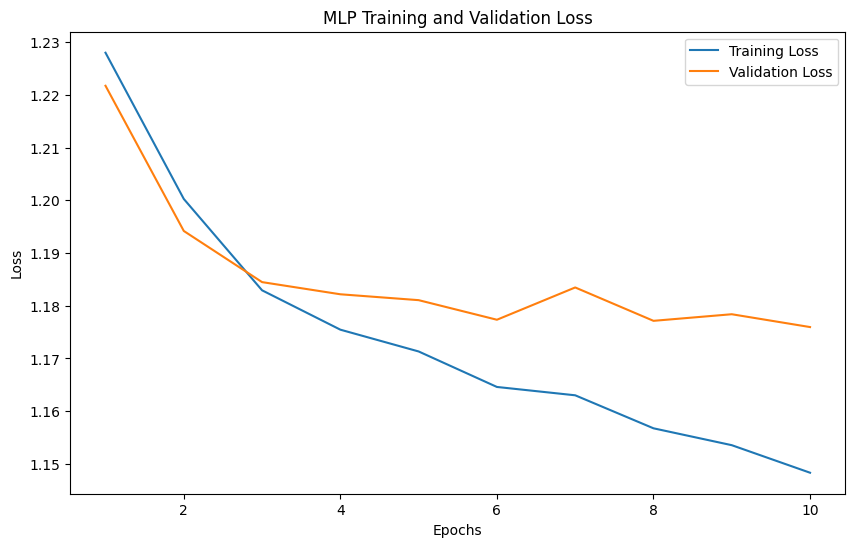

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, mlp_num_epochs + 1), mlp_train_losses, label="Training Loss")
plt.plot(range(1, mlp_num_epochs + 1), mlp_val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("MLP Training and Validation Loss")
plt.legend()
plt.show()

In [10]:
# Obtain predictions on test set for evaluation

mlp_predictions = []
mlp_probs = []
mlp_model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = mlp_model(inputs)
        probs = torch.sigmoid(outputs)
        predicted = torch.round(probs)
        mlp_predictions.extend(predicted.cpu().numpy())
        mlp_probs.extend(probs.cpu().numpy())

## Linear Regression model

In [11]:
######### HYPERPARAMETERS #########
lr_input_dim = X_train.shape[1]
lr_output_dim = 1

lr_learning_rate = 1e-4
lr_num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else device)
###################################

lr_model = LinearRegressionModel(
    input_dim=lr_input_dim,
    output_dim=lr_output_dim,
)
print(lr_model)

LinearRegressionModel(
  (linear): Linear(in_features=2352, out_features=1, bias=True)
)


In [12]:
lr_loss = torch.nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([pos_weight], dtype=torch.float32).to(device)
)
lr_optimizer = torch.optim.Adam(lr_model.parameters(), lr=lr_learning_rate)

lr_train_losses, lr_val_losses = train_torch_model(
    model=lr_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=lr_loss,
    optimizer=lr_optimizer,
    num_epochs=lr_num_epochs,
    device=device,
)

Epoch 1/10, Loss: 1.2142
Validation Loss: 1.2132
Epoch 2/10, Loss: 1.1881
Validation Loss: 1.1984
Epoch 3/10, Loss: 1.1778
Validation Loss: 1.1923
Epoch 4/10, Loss: 1.1730
Validation Loss: 1.1889
Epoch 5/10, Loss: 1.1696
Validation Loss: 1.1869
Epoch 6/10, Loss: 1.1677
Validation Loss: 1.1852
Epoch 7/10, Loss: 1.1655
Validation Loss: 1.1843
Epoch 8/10, Loss: 1.1640
Validation Loss: 1.1843
Epoch 9/10, Loss: 1.1625
Validation Loss: 1.1855
Epoch 10/10, Loss: 1.1608
Validation Loss: 1.1854


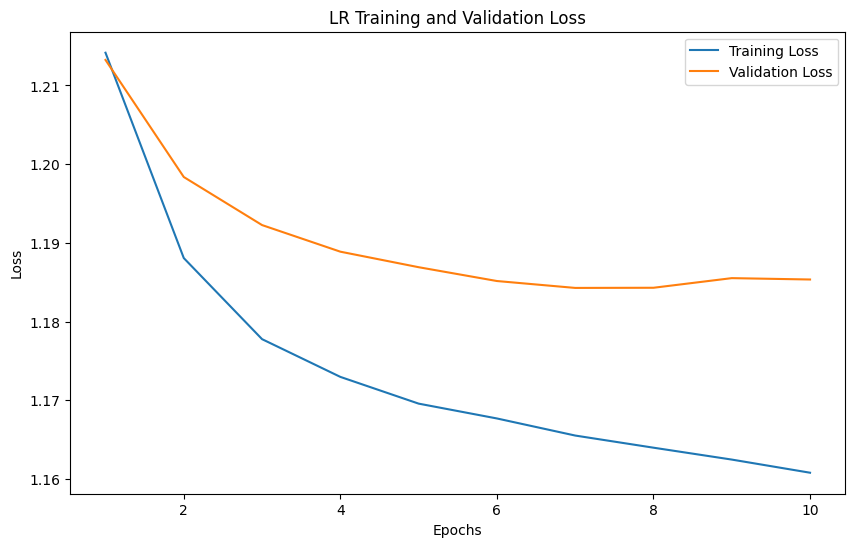

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, lr_num_epochs + 1), lr_train_losses, label="Training Loss")
plt.plot(range(1, lr_num_epochs + 1), lr_val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LR Training and Validation Loss")
plt.legend()
plt.show()


In [14]:
# Obtain predictions on test set for evaluation

lr_predictions = []
lr_probs = []
lr_model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = lr_model(inputs)
        probs = torch.sigmoid(outputs)
        predicted = torch.round(probs)
        lr_predictions.extend(predicted.cpu().numpy())
        lr_probs.extend(probs.cpu().numpy())

## Random Forest model

In [15]:
######### HYPERPARAMETERS #########
rf_n_estimators = 100
rf_max_depth = None
###################################

rf_model = RandomForestModel(
    n_estimators=rf_n_estimators,
    max_depth=rf_max_depth,
)

print(rf_model.model)

RandomForestClassifier(class_weight='balanced')


In [16]:
rf_model.fit(X_train, y_train.flatten())
rf_predictions = rf_model.predict(X_test)
rf_probs = rf_model.model.predict_proba(X_test)[:, 1]

## XGBoost model

In [17]:
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3],
    "subsample": [0.8, 1.0],
}

neg, pos = np.bincount(y_train.flatten())
pos_weight = neg / pos


xgb_base = XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=pos_weight,
    random_state=42,
)

grid_search = GridSearchCV(
    estimator=xgb_base, param_grid=param_grid, scoring="f1", cv=3, verbose=1, n_jobs=-1
)
print(grid_search)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=N

In [18]:
grid_search.fit(X_train, y_train)


xgb_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

xgb_predictions = xgb_model.predict(X_test)
xgb_probs = xgb_model.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


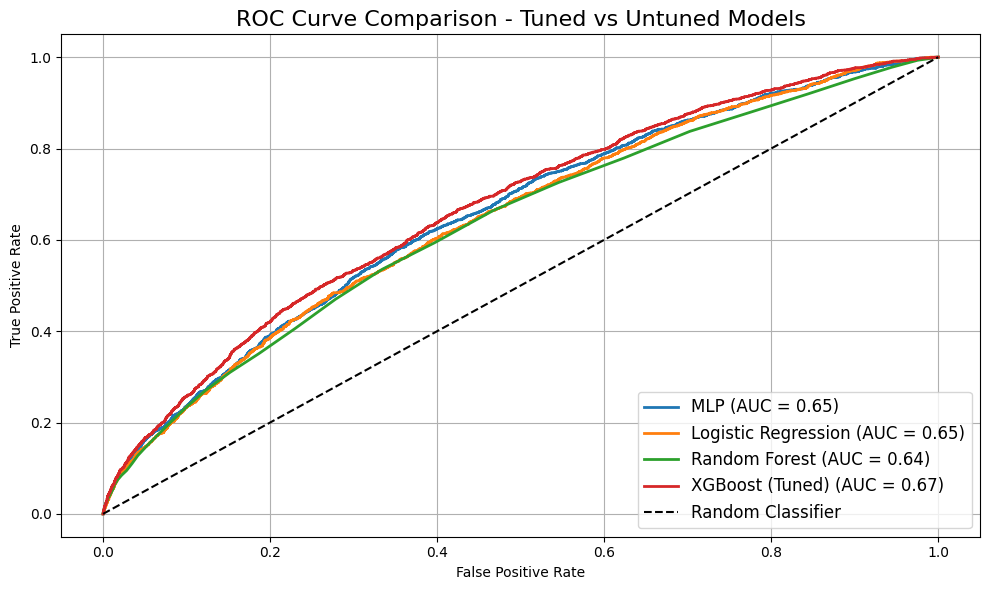

In [19]:
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_tuned_fpr, xgb_tuned_tpr, _ = roc_curve(y_test, xgb_probs)

mlp_auc = auc(mlp_fpr, mlp_tpr)
lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
xgb_tuned_auc = auc(xgb_tuned_fpr, xgb_tuned_tpr)

plt.figure(figsize=(10, 6))

plt.plot(mlp_fpr, mlp_tpr, label=f"MLP (AUC = {mlp_auc:.2f})", linewidth=2)
plt.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC = {lr_auc:.2f})", linewidth=2)
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (AUC = {rf_auc:.2f})", linewidth=2)
plt.plot(
    xgb_tuned_fpr,
    xgb_tuned_tpr,
    label=f"XGBoost (Tuned) (AUC = {xgb_tuned_auc:.2f})",
    linewidth=2,
)

plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")

plt.title("ROC Curve Comparison - Tuned vs Untuned Models", fontsize=16)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# Evaluation

In [ ]:
print("MLP Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, mlp_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, mlp_predictions))

MLP Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.58      0.71     13518
           1       0.16      0.64      0.26      1747

    accuracy                           0.58     15265
   macro avg       0.54      0.61      0.49     15265
weighted avg       0.84      0.58      0.66     15265

Confusion Matrix:
 [[7774 5744]
 [ 622 1125]]


In [ ]:
print("Linear Regression Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, lr_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, lr_predictions))

Linear Regression Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.74      0.82     13518
           1       0.19      0.46      0.27      1747

    accuracy                           0.71     15265
   macro avg       0.55      0.60      0.54     15265
weighted avg       0.83      0.71      0.76     15265

Confusion Matrix:
 [[10030  3488]
 [  943   804]]


In [ ]:
print("Random Forest Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, rf_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_predictions))

Random Forest Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     13518
           1       0.75      0.00      0.00      1747

    accuracy                           0.89     15265
   macro avg       0.82      0.50      0.47     15265
weighted avg       0.87      0.89      0.83     15265

Confusion Matrix:
 [[13517     1]
 [ 1744     3]]


In [ ]:
print("XGBoost Model Evaluation:")
print("Classification Report:\n", classification_report(y_test, xgb_predictions))
print("Confusion Matrix:\n", confusion_matrix(y_test, xgb_predictions))

XGBoost Model Evaluation:
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.64      0.76     13518
           1       0.18      0.59      0.27      1747

    accuracy                           0.64     15265
   macro avg       0.55      0.61      0.51     15265
weighted avg       0.84      0.64      0.70     15265

Confusion Matrix:
 [[8704 4814]
 [ 724 1023]]


# XAI

## Global XAI

In [29]:
feature_names = preprocessor.get_feature_names_out()

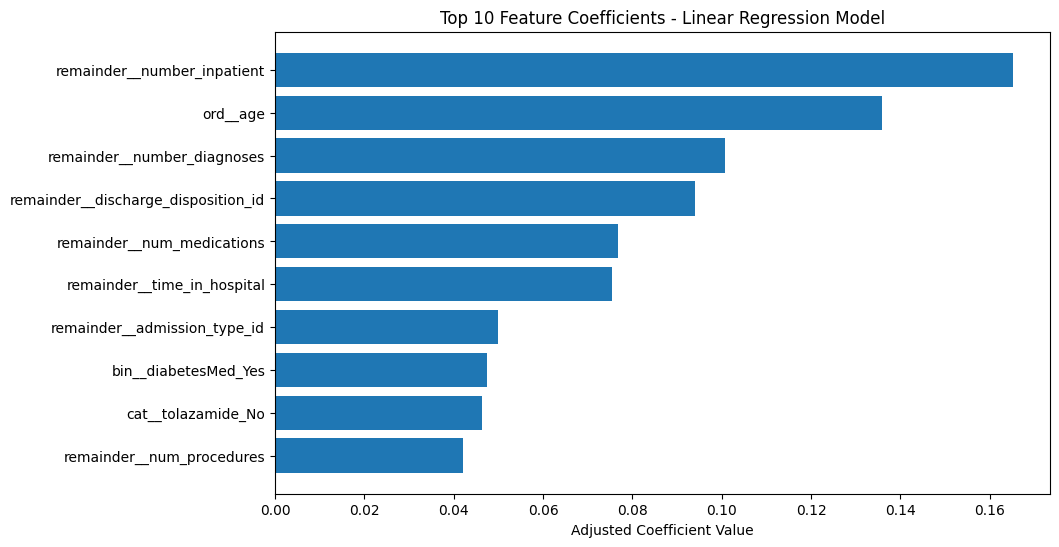

In [ ]:
# Plot linear regression parameters, taking into account feature magnitudes
lr_params = lr_model.linear.weight.detach().cpu().numpy().flatten()
feature_means = np.mean(X_train, axis=0)
adjusted_params = np.abs(lr_params * feature_means)

k = 10
topk_idx_lr = np.argsort(np.abs(adjusted_params))[-k:][::-1]
plt.figure(figsize=(10, 6))
plt.barh(
    range(k),
    adjusted_params[topk_idx_lr][::-1],
    align="center",
)
plt.yticks(range(k), feature_names[topk_idx_lr][::-1])
plt.xlabel("Adjusted Coefficient Value")
plt.title("Top 10 Feature Coefficients - Linear Regression Model")
plt.show()

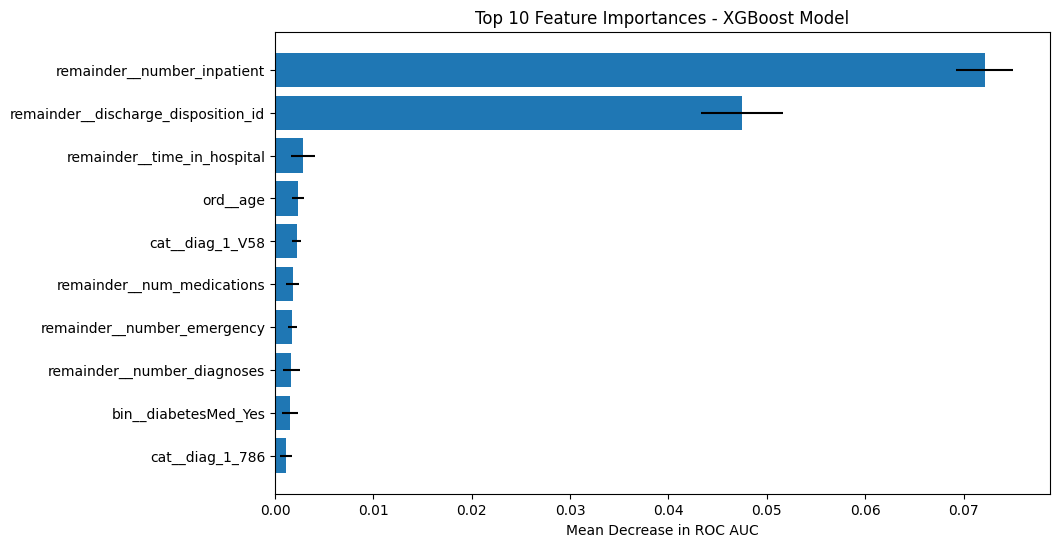

In [ ]:
k = 10
xgb_result = permutation_importance(
    xgb_model, X_test, y_test, n_repeats=5, random_state=21, scoring="roc_auc"
)
topk_idx = xgb_result.importances_mean.argsort()[-k:][::-1]

plt.figure(figsize=(10, 6))
plt.barh(
    range(k),
    xgb_result.importances_mean[topk_idx][::-1],
    xerr=xgb_result.importances_std[topk_idx][::-1],
    align="center",
)
plt.yticks(range(k), feature_names[topk_idx][::-1])
plt.xlabel("Mean Decrease in ROC AUC")
plt.title("Top 10 Feature Importances - XGBoost Model")
plt.show()

## Local XAI

In [42]:
explainer_xgb = shap.Explainer(xgb_model)
X_test_df = pd.DataFrame(X_test, columns=feature_names)
shap_values_xgb = explainer_xgb(X_test_df)

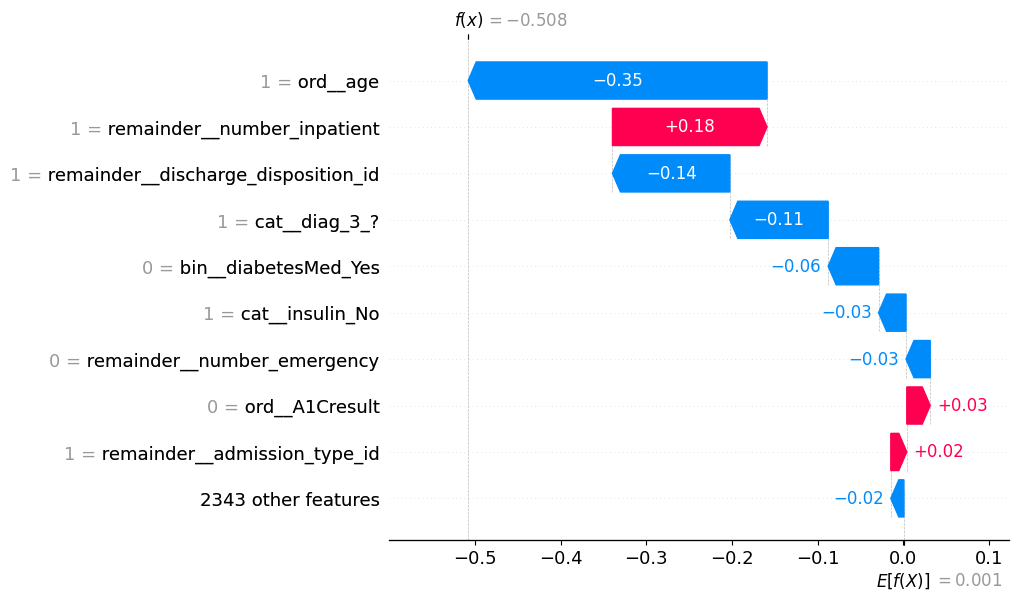

In [49]:
shap.plots.waterfall(shap_values_xgb[0], max_display=10)

# Sanity Checks

## Data Randomization Test


--- Sanity Check Results ---
Spearman Rank Correlation: 0.0383
Result: PASS. The explanations are very different (Low Correlation).


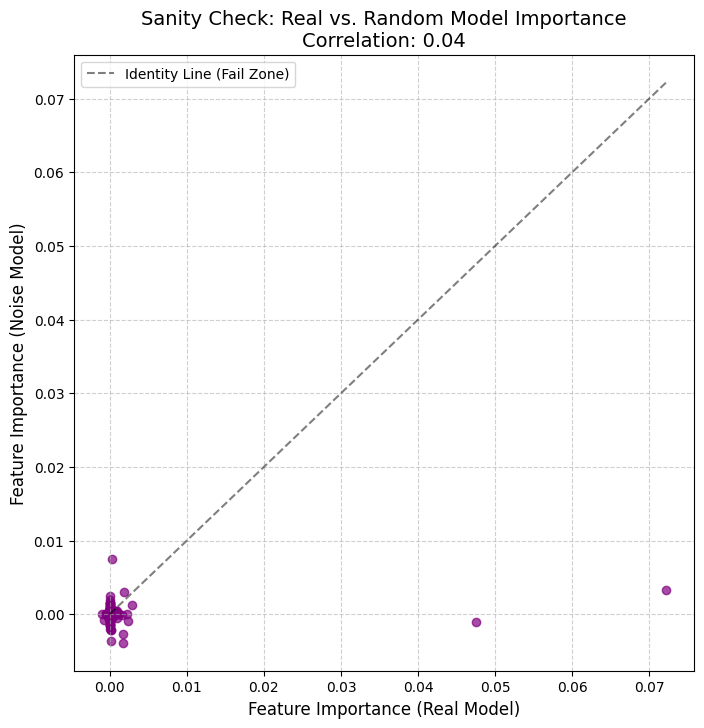

In [53]:
y_train_shuffled = np.random.permutation(y_train)

xgb_params = xgb_model.get_params()
noise_model = XGBClassifier(
    **xgb_params,
)

noise_model.fit(X_train, y_train_shuffled.flatten())

noise_result = permutation_importance(
    noise_model,
    X_test,
    y_test.flatten(),
    n_repeats=5,
    random_state=42,
    scoring="roc_auc",
)

real_importance = xgb_result.importances_mean
noise_importance = noise_result.importances_mean

correlation, p_value = spearmanr(real_importance, noise_importance)

print("\n--- Sanity Check Results ---")
print(f"Spearman Rank Correlation: {correlation:.4f}")
if abs(correlation) < 0.2:
    print("Result: PASS. The explanations are very different (Low Correlation).")
elif abs(correlation) < 0.5:
    print(
        "Result: CAUTION. There is some similarity between real and noise explanations."
    )
else:
    print(
        "Result: FAIL. The explanations look similar even with random labels (High Correlation)."
    )

plt.figure(figsize=(8, 8))
plt.scatter(real_importance, noise_importance, alpha=0.7, color="purple")
plt.title(
    f"Sanity Check: Real vs. Random Model Importance\nCorrelation: {correlation:.2f}",
    fontsize=14,
)
plt.xlabel("Feature Importance (Real Model)", fontsize=12)
plt.ylabel("Feature Importance (Noise Model)", fontsize=12)

# Points close to the y=x line indicate the sanity check failed.
max_val = max(max(real_importance), max(noise_importance))
plt.plot(
    [0, max_val], [0, max_val], "k--", alpha=0.5, label="Identity Line (Fail Zone)"
)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


## ROAD

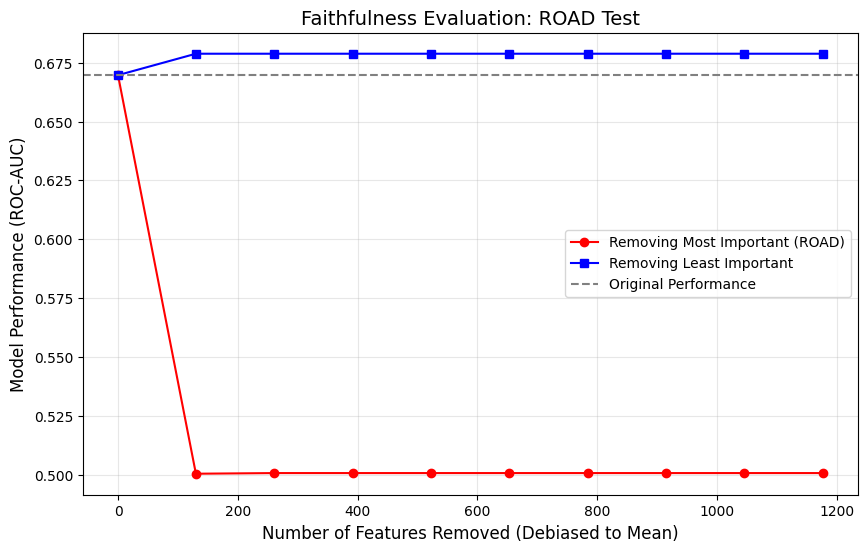

Initial AUC: 0.6697
AUC after removing top 1176 features: 0.5007


In [55]:
def road_evaluation(model, X, y, importance_scores, feature_names, steps=10):
    """
    Implements the ROAD (Remove And Debias) faithfulness test.
    Gradually replaces the most important features with their mean value
    and measures the drop in ROC-AUC.
    Finally, plots the faithfulness curve.
    """
    sorted_indices = np.argsort(importance_scores)[::-1]

    least_important_indices = np.argsort(importance_scores)

    auc_most_important = []
    auc_least_important = []

    num_features = X.shape[1]
    feature_steps = np.linspace(0, int(num_features * 0.5), steps, dtype=int)

    baseline_auc = roc_auc_score(y, model.predict_proba(X)[:, 1])

    for k in feature_steps:
        X_removed_most = X.copy()
        if isinstance(X_removed_most, pd.DataFrame):
            for idx in sorted_indices[:k]:
                col = feature_names[idx]
                X_removed_most[col] = X_removed_most[col].mean()
        else:
            for idx in sorted_indices[:k]:
                X_removed_most[:, idx] = np.mean(X_removed_most[:, idx])

        X_removed_least = X.copy()
        if isinstance(X_removed_least, pd.DataFrame):
            for idx in least_important_indices[:k]:
                col = feature_names[idx]
                X_removed_least[col] = X_removed_least[col].mean()
        else:
            for idx in least_important_indices[:k]:
                X_removed_least[:, idx] = np.mean(X_removed_least[:, idx])

        auc_most_important.append(
            roc_auc_score(y, model.predict_proba(X_removed_most)[:, 1])
        )
        auc_least_important.append(
            roc_auc_score(y, model.predict_proba(X_removed_least)[:, 1])
        )

    plt.figure(figsize=(10, 6))
    plt.plot(
        feature_steps,
        auc_most_important,
        marker="o",
        label="Removing Most Important (ROAD)",
        color="red",
    )
    plt.plot(
        feature_steps,
        auc_least_important,
        marker="s",
        label="Removing Least Important",
        color="blue",
    )
    plt.axhline(
        y=baseline_auc, color="gray", linestyle="--", label="Original Performance"
    )

    plt.title("Faithfulness Evaluation: ROAD Test", fontsize=14)
    plt.xlabel("Number of Features Removed (Debiased to Mean)", fontsize=12)
    plt.ylabel("Model Performance (ROC-AUC)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Initial AUC: {baseline_auc:.4f}")
    print(
        f"AUC after removing top {feature_steps[-1]} features: {auc_most_important[-1]:.4f}"
    )


road_evaluation(
    model=xgb_model,
    X=X_test,
    y=y_test,
    importance_scores=xgb_result.importances_mean,
    feature_names=feature_names,
)
